In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")  
print(f"Using device: {device}")

Using device: cuda:2


In [2]:
import pickle

with open('/home/gdlteam3/all_abbasid_poems.pkl', 'rb') as file:
    data = pickle.load(file)

In [6]:
import numpy as np
import pandas as pd
from datasets import Dataset
from tqdm.auto import tqdm  # This auto-detects the environment (Jupyter/Terminal)


# Convert numpy array to DataFrame with column name "text"
df_data = pd.DataFrame(data, columns=["text"])
df_data = df_data.sample(n=5000, random_state=42)  
dataset = Dataset.from_pandas(df_data)

# Split into 80% train / 20% validation
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

In [7]:
# -*- coding: utf-8 -*-

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "UBC-NLP/AraT5v2-base-1024"

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)


In [8]:
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding

# Tokenize the text data (batch tokenization)
def tokenize_function(examples):
    instruction = ["اكتب قصيدة عباسية:" for _ in examples["text"]]
    model_inputs = tokenizer(instruction, truncation=True, padding="max_length", max_length=512)
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=512,
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the tokenizer to the training and validation datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model, label_pad_token_id=-100)

args = Seq2SeqTrainingArguments(
    output_dir="arat5-finetuned",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    generation_max_length=256,
    load_best_model_at_end=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
)


/home/gdlteam3/anaconda3/envs/arat5/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,7.448600,2.243938
2,2.066300,1.666311
3,1.839400,1.605757
4,1.788300,1.578616
5,1.765100,1.570408


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=2500, training_loss=2.9815122802734373, metrics={'train_runtime': 1690.4472, 'train_samples_per_second': 11.831, 'train_steps_per_second': 1.479, 'total_flos': 1.737942368256e+16, 'train_loss': 2.9815122802734373, 'epoch': 5.0})

In [28]:
model.save_pretrained("./arat5_finetuned")
tokenizer.save_pretrained("./arat5_finetuned")

('./arat5_finetuned/tokenizer_config.json',
 './arat5_finetuned/special_tokens_map.json',
 './arat5_finetuned/spiece.model',
 './arat5_finetuned/added_tokens.json',
 './arat5_finetuned/tokenizer.json')

In [21]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the saved model and tokenizer
model_path = "./arat5_finetuned"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move model to the appropriate device (GPU if available)
device = "cpu"
model = model.to(device)

In [16]:
import torch
model.eval()  # Set model to evaluation mode

def generate_poem(prompt, max_len=200):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_length=max_len,
        do_sample=True,         
        top_p=0.9,
        temperature=0.9,
        repetition_penalty=1.1,
        no_repeat_ngram_size=4,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Generate a poem with a given prompt
prompt = "اكتب قصيدة عباسية عن الحب والحنين إلى بغداد:"
print(generate_poem(prompt))


قَد حُفرَت إِلى الشَربِ بِالصَبابِ. وَمَن عُقِبَت مِن نَفسٍ لَم يَضرِب. صَيباً لِلخُبْ بِها. فَما أَو اِستُطَبُّ بُياهُ. فَما اِستَعَدَتْ إِن أُجَلّيتَ أَن تُدُرَّ في البَينِ . فَلَم تَغْفَرُ هَوى الأَحوالِ مِن زَمانِهِ المُحَرَّمُ. وَإِذا مَا خَطَيبُهُ وَالمُتَطيلُهُ. وَرَقَليلٌ وَلا يَينِ الدَهرَةِ القُندَهُ. وَتَزَوتَ يَيرَهُمّى سَليهِ. لِفظَيهُ عَنِّي عُني. وَالنَفَعثِيارِها دَينِ. كَأَنَّها غَهرِ ع


In [30]:
prompts = [
    "اكتب قصيدة عن الشجاعة في ساحات القتال:",
    "اكتب قصيدة عن جمال النخيل على ضفاف دجلة:",
    "اكتب قصيدة عن الحب والحنين إلى بغداد:",
    "اكتب قصيدة على بحر الكامل في مدح العلم:",
    "اكتب قصيدة من عشرة أبيات عن سفر التاجر عبر الصحراء:",
    "اكتب عباسية عن ليلة قمرية في البادية:",
    "اكتب قصيدة عن الفلسفة وعظمة العقل البشري:",
    "اكتب قصيدة عن زوال الدنيا وسرعة الفناء:",
    "اكتب قصيدة على قافية الميم في رثاء صديق:",
    "اكتب قصيدة طويلة عن عظمة الخلافة العباسية:"
]

for p in prompts:
    print(generate_poem(p))
    print("\n\n")


بِذي اللَيلِ قَد أَنتَ بُينَ. تَرَقتُ خَيالَهُم سَلَقاً وَتَعَلى صَفاً وَمَتَعَلّى. وَرَشدتُهُمُ حُسنُ البَعدُ قَلبا. وَلا يَستَغفى مِنَ التَعريضِ مُهَجَّةٌ. إِذا ما نَجدَت العُهدُ جَرَى. وَيُنادى الحَتّاءُ جَلبٌ غادَرَوا. إِذا عَما كَلَّقى الضُّرٍ. وَأَشَتوا لَيسَيسَ في القُلتَنا عُقْبيحا. وَكُلِّتُ الأَصَّي بِالسِها الرَمرِسا. وَعَدواهُمَوقِرا. 



ألا وَلا كَأَنَّكَ مُستَغْدَرَني. لا تَدنْيني وَالحَقّي بِالسُلاحِ. وَهو مِن بَعدٍ لَها غَذَبَتني. 



مِن حَسَدٍ فَما لَهوى. فَلَو كانَ قُلبَ غِيرٍ. 



إِلى عَينِ الخُلِقُ يَغْري. وَأَن لَم أَنا خُفَّتُ مِن فَاِرضٍ. فَهوَ لا تَذَرُ اللَهْ وَالمَعزُ. وَلَقَد رَينا بَلغَ عَن طَرْبِ التَخيرِ وَالخَصَفَّةِ. لِإِذا شَيءَت هُمْ في غَيرِهِ وَمُسمِعِه. لَسَقَطَت عَلَيَّ العَرضَ لَو أَن جَبلَكَ الفَهرِبتي وَلا. فَقَدِّ بِالعَيفُ المَليلَةِ الحُبِسُ. 



اِستَكِنْتُ مِن لَيسَةِ القِلبِ. وَلا حَتّى قَلتُ أَما صَبِّيتُها مُعتَرَفا. وَإِذا ما شَمَتْ بَينَ النَفسِ عَن غَريبِها. أَو شَمتُك بِالأَرغامِ المَوتِ فَما تُعذَرُ. إِذا كَسَرتُ أُحِبُّ بِالحُسن

In [20]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def calculate_self_bleu(generated_texts):
    smoothing_function = SmoothingFunction().method1
    bleu_scores = []

    for i, text in enumerate(generated_texts):
        # Use all other texts as reference
        references = [nltk.word_tokenize(t) for j, t in enumerate(generated_texts) if j != i]
        hypothesis = nltk.word_tokenize(text)
        
        # Calculate BLEU score for this text with smoothing
        score = sentence_bleu(references, hypothesis, smoothing_function=smoothing_function)
        bleu_scores.append(score)
    
        # Calculate the average BLEU score
    average_bleu = np.mean(bleu_scores)
    
    return bleu_scores, average_bleu

# Example usage with your generated poems
generated_poems = [
    'إذا ما لم تُعدَ الخُلَّطُ مِنه. لَم يَعمَلَت العَزْلَ مُقرَبٍ فيه. سَيّا نِجدُها. كُتبتْ في الحِمْنِ ما تَنتَحُ. دُنوَّما حَياً عَن مِن خَصَرِهِ. جُدْتَ في الضُّرِّ وَما أَتى. إِذا ما عَلَيتُ أَن يُعادِلُه. لِصَدِّي لَو كانَ بِالجَمْرِ عَجاعنٍ. شَأزَيسَلى المُرَّي.',
    'أَمرٌ مَن كانَ بِالعِندُ مُفَلِّداً. لَم تَجدْ شَغلاً إِلى صُدّا. وَقالُوا عَن اللَهِ وَالقَلبِ مُفَرَّداً. فَإِن سُرَّكَ وَالبُينِ كَأَنَّها. وَما يَرضى وَيَشقى مَا نَدى. وَأَردَى الأَولاءِ يُشَيَدونُ في مَثلِ المَلامِعَاتِ. لَو لَمْ يَعِدوا دَلي لِمَنكَبُ. لَقُلتُ المُقتَطولا. وَمِن حُلّى مِن ذَكِبْتُكٍ وَلَرَت عَيلَيتُهُ في جَهْ. فَفي خَبائِقِ الصَستَعدَباً تُؤيا. ',
    'يا طَوْباً حَطّاً في شَفائِ. ولَم أُعجبُ لِغَيرٍ لا يُخلِفُه. إِذا جَنَّبته مُخَذَرَةٌ.',
    'لو أنَّها في جَفْنِ جَهْدٍ. لو كان فيها مَثلَ رُؤياً. لم يكنَ سَلبٌ ما كانَ وَلا رَفعِ. من حَلّى سَلَّمَتْ نَدَا. في الأُسْرارِ دَهرُ قَلبٍ وَلا أَسرَمِ. ',
    'يا ذا كَبشٍ أُوَيتُ في النَفسِ. إنَّما حَزَنَتني عُرفُ ما. أَزَجرتَ العَيالي على عَن قُبٍّ. نَدمتْ عن زَمّا تَطوى. مِن شُقَدِ صِبْرِ يَومٍ بِالأَغصْبِ. ',
    'أَو أَظُبتَ في البَينِ. وَمَن قَد وَما شَقِينا في البَلَلِ. ',
    'يا مُعتَفِلاً في صِبحِ الفِكرِ. لا حَسَيتُ بَرداً أَو نَدا. رَأَيتَ ما يَحدثُ عَن فَما تُعطي لَها مَدى الرِجالِ. لا زِلْتُ بَعدَهُم شَبابِ العَصائبِ. كَأَنتَ بِالقَيامِ وَالتَكْثيرِ. وَاِقتِدِّتُ جُرداً لَيسَ إِذا سَرى. خَطِينا دُرّاً قَلبي. تُرتِ مِن تَغدي. عَوى لِسَستَت عِلى مِن لَمياً. وَرَقَد عِقاً لَهُ عَنظائِحٍ وَالخَبا. وَسَعَمي مَستَعَيّي اِسمِعراً. فَأَضَهرِ الدِها',
    'يا ابن جلاء الحِكم في اللَهِ. يا ذا القِلبِ يَحبُّكَ الفَقرُ. ',
    'أَرضَيتُ وَالحَقائِرِ بِها. رَأيٌ حَسَنُ مَن كانَ يَناخِرُ خَفيَه. شَيءُهُ في بُرودِهِ. فَلا يَعرَمُ قَلبي عِلمُهُ. وَلَو جَفَّرَتْ فَاِن لَم تَشتَقَى القَلبَ أَن يَرى المَسكَراً وَمَعدَكا. وَما تَطَعَرتُ مَنتَظِرَ الدُهرَ وَغَفُدُرُّهُم إِذا صَدتَيلَةَ الصَينَ وَلا تُنّا. وَالعَجِدُ الهَوى هَذَلى الجَربَهُ. وَمَندُهْنهِ كُنْتُ في البَدى الحَشَرِيلا دَعلَها. مِقتَصِروَّتي لَوِداكي فِي نَينَنى. وَق',
    'أَلا كَأَنَّما نُسى. فَلَم تُنَفْنا بَعدَ حَنّيِها شِيءٌ لا أُحمِلُ. عُقِرَتْ عَلَينا قَرْنَ الحَمامُ فُرقاً لَيسا. '
]

self_bleu_scores, average_bleu = calculate_self_bleu(generated_poems)
print("Self-BLEU Scores:", self_bleu_scores)
print(f"Average Self-BLEU Score: {average_bleu:.4f}")

Self-BLEU Scores: [0.013823166652699606, 0.0150518945537582, 0.03557982867938776, 0.01062528138445703, 0.018899393635549322, 0.024526890693591246, 0.005941250833793474, 0.04324227075463215, 0.013423611401828715, 0.014400124446705301]
Average Self-BLEU Score: 0.0196


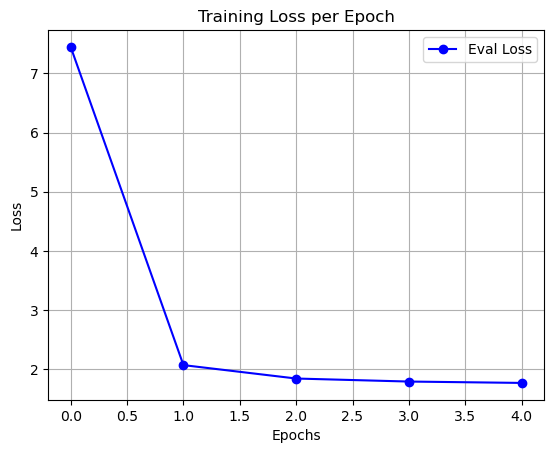

In [25]:
import matplotlib.pyplot as plt
import json

# Load the JSON file
with open("/home/gdlteam3/AraT5/arat5-finetuned/checkpoint-2500/trainer_state.json", "r", encoding="utf-8") as f:
    train_state = json.load(f)

# Extract all eval_loss values from log_history
losses = [
    entry["loss"]
    for entry in train_state.get("log_history", [])
    if "loss" in entry
]

# Plotting
plt.plot(eval_losses, marker='o', color='b', label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

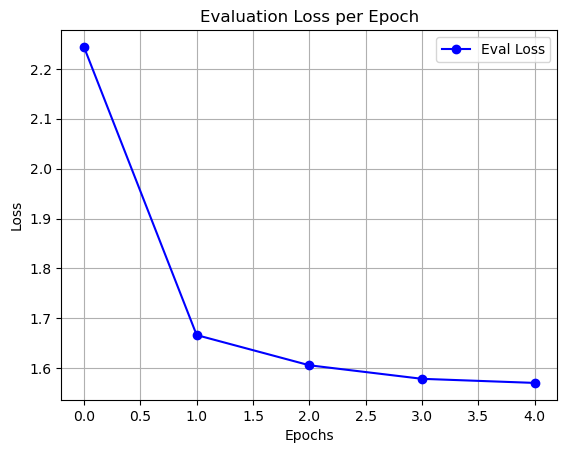

In [26]:
import matplotlib.pyplot as plt
import json

# Load the JSON file
with open("/home/gdlteam3/AraT5/arat5-finetuned/checkpoint-2500/trainer_state.json", "r", encoding="utf-8") as f:
    train_state = json.load(f)

# Extract all eval_loss values from log_history
eval_losses = [
    entry["eval_loss"]
    for entry in train_state.get("log_history", [])
    if "eval_loss" in entry
]

# Plotting
plt.plot(eval_losses, marker='o', color='b', label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


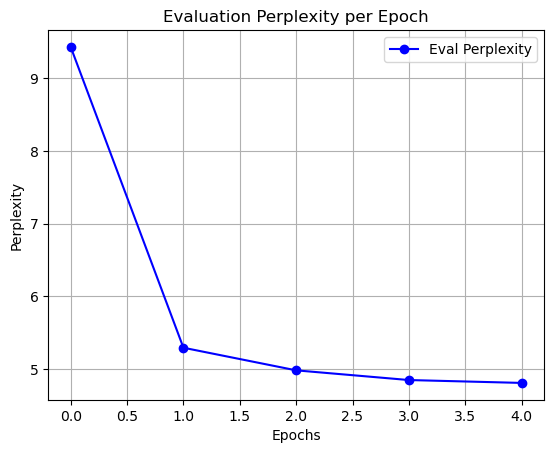

In [27]:
import math

perplexities = [math.exp(loss) for loss in eval_losses]

# Plotting
plt.plot(perplexities, marker='o', color='b', label='Eval Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Evaluation Perplexity per Epoch')
plt.legend()
plt.grid(True)
plt.show()